
# 小地域の収入推定

```Data```フォルダには、小地域の収入データ(```income_district.csv```)と国勢調査の小地域集計データが格納されています。

国勢調査の小地域集計データ（人口構成、労働力構成、住宅形態など）から、その地域の収入を推定することが考えられます。推定のための機械学習・深層学習モデルを構築しなさい。


- データを観察・理解する上で、データの構造を説明しながら、適切なデータ整形を行いなさい
- データ構造や分析結果に対して、少なくとも二つの図で可視化を行いなさい
- モデルの精度を評価し、できるだけ精度が高いモデルを得るよう、適切な特徴量エンジニアリングやモデル選定の考えもまとめなさい


In [ ]:
!pip install lightgbm
!pip install japanize_matplotlib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from functools import reduce
import japanize_matplotlib
import os

In [ ]:
# -データを観察・理解する上で、データの構造を説明しながら、適切なデータ整形を行いなさい

In [ ]:
#データの読み込み
os.chdir(r'C:\Users\shu16\OneDrive\ドキュメント\呂演習')

dataframes_census = {
    'age': pd.read_csv('h27_age_df.csv'),
    'family': pd.read_csv('h27_family_df.csv'),
    'gender': pd.read_csv('h27_gender_df2.csv'),
    'house': pd.read_csv('h27_house_df.csv'),
    'house_info': pd.read_csv('h27_house_info_df.csv'),
    'industry': pd.read_csv('h27_indusry_df.csv'),
    'job': pd.read_csv('h27_job_df.csv'),
    'labor': pd.read_csv('h27_labor_df.csv'),
    'marriage': pd.read_csv('h27_marriage_df.csv'),
    'work_status': pd.read_csv('h27_work_status_df.csv')
}
df_income = pd.read_csv('income_district.csv')

#データ結合と整形
##dataframes_censusに共通したキーは以下の7つ
##それを基に結合する
key_columns = [
    'district_id', 'district2_id', 'level_identifier',
    'state_name', 'city_name', 'district_name', 'district2_name'
]
df_census_merged = reduce(lambda left, right: pd.merge(left, right, on=key_columns, how='outer'), dataframes_census.values())

df_income.rename(columns={'area_code': 'district_id'}, inplace=True)
final_df = pd.merge(df_census_merged, df_income, on='district_id', how='left')

##欠損値処理
##文字列を数値変換
##重複変数の除去実行
final_df.dropna(subset=['income_mean'], inplace=True)

numeric_cols_to_convert = final_df.columns.drop(key_columns + ['income_mean'], errors='ignore')
for col in numeric_cols_to_convert:
    if final_df[col].dtype == 'object':
        final_df[col] = pd.to_numeric(final_df[col], errors='coerce')

final_df.fillna(0, inplace=True)

if 'family_count_y' in final_df.columns:
    final_df.drop('family_count_y', axis=1, inplace=True)
    final_df.rename(columns={'family_count_x': 'family_count'}, inplace=True)


In [ ]:
# -データ構造や分析結果に対して、少なくとも二つの図で可視化を行いなさい

c:\Users\shu16\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27507 (\N{CJK UNIFIED IDEOGRAPH-6B73}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\shu16\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\shu16\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\shu16\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\shu16\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) Arial.
  fig.canvas.print_figure(

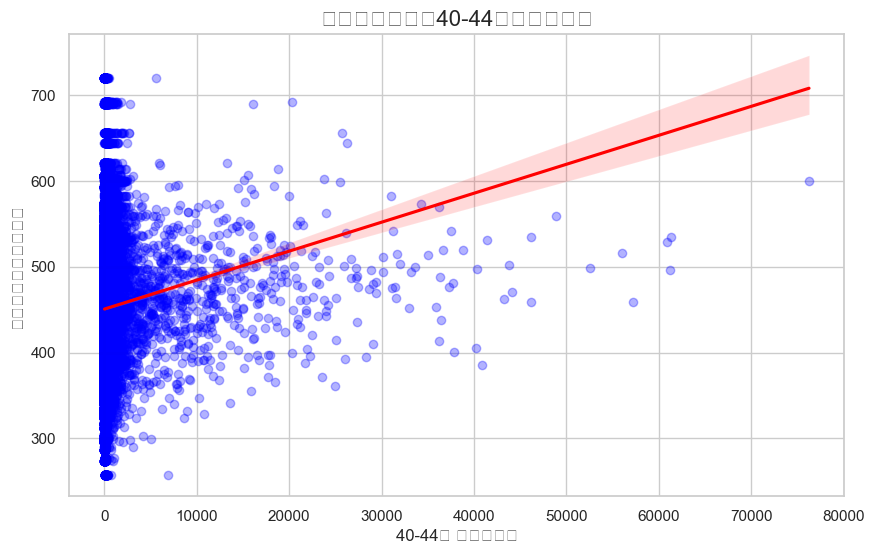

c:\Users\shu16\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\shu16\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\shu16\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21454 (\N{CJK UNIFIED IDEOGRAPH-53CE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\shu16\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\shu16\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) Arial.
  fig.canvas.print_figure(b

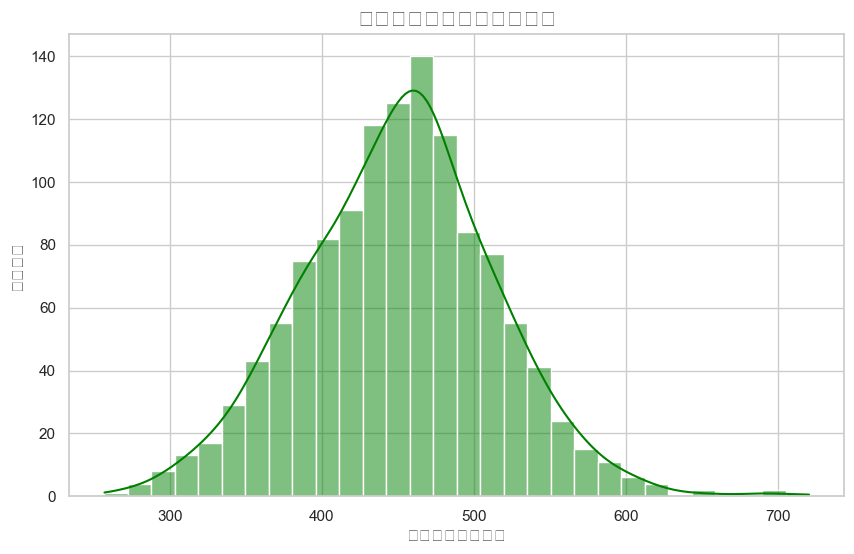

In [ ]:
#データの可視化
sns.set(style='whitegrid')

#可視化1: 散布図
plt.figure(figsize=(10, 6))
sns.regplot(data=final_df, x='40-44', y='income_mean',
            scatter_kws={'alpha':0.3, 'color':'blue'}, line_kws={'color':'red'})
plt.title('地区平均収入と40-44歳人口の関係', fontsize=16)
plt.xlabel('40-44歳 人口（人）', fontsize=12)
plt.ylabel('地区平均収入（万円）', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True)
plt.show()

#可視化2: ヒストグラム
plt.figure(figsize=(10, 6))
income_unique = final_df[['district_id', 'income_mean']].drop_duplicates()
sns.histplot(income_unique['income_mean'], kde=True, bins=30, color='green')
plt.title('地区ごとの平均収入の分布', fontsize=16)
plt.xlabel('平均収入（万円）', fontsize=12)
plt.ylabel('地区の数', fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
#- モデルの精度を評価し、できるだけ精度が高いモデルを得るよう、適切な特徴量エンジニアリングやモデル選定の考えもまとめなさい
##特徴量エンジニアリングとは、相関の低い変数や情報量の乏しい項目、欠損値を適切に処理し、モデルの性能向上や解釈性の向上を目的として、新たな有用な特徴量を創出・選定するプロセスである。
##モデル選定とは、複数のアルゴリズムを比較検証することで、過学習のリスクを抑えつつ、予測精度を最大化する最適なモデルを選び出す手法である。

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46159
[LightGBM] [Info] Number of data points in the train set: 182609, number of used features: 188
[LightGBM] [Info] Start training from score 451.171005
テストデータでのRMSE: 41.61


C:\Users\shu16\AppData\Local\Temp\ipykernel_12608\3149150639.py:32: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\shu16\AppData\Local\Temp\ipykernel_12608\3149150639.py:32: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\shu16\AppData\Local\Temp\ipykernel_12608\3149150639.py:32: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\shu16\AppData\Local\Temp\ipykernel_12608\3149150639.py:32: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\shu16\AppData\Local\Temp\ipykernel_12608\3149150639.py:32: UserWarning: Glyph 24500 (\N{CJK UNIFIED IDEOGRAPH-5FB4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\shu16\AppData\Local\Temp\ipykernel_12608\3149150639.py:32: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF})

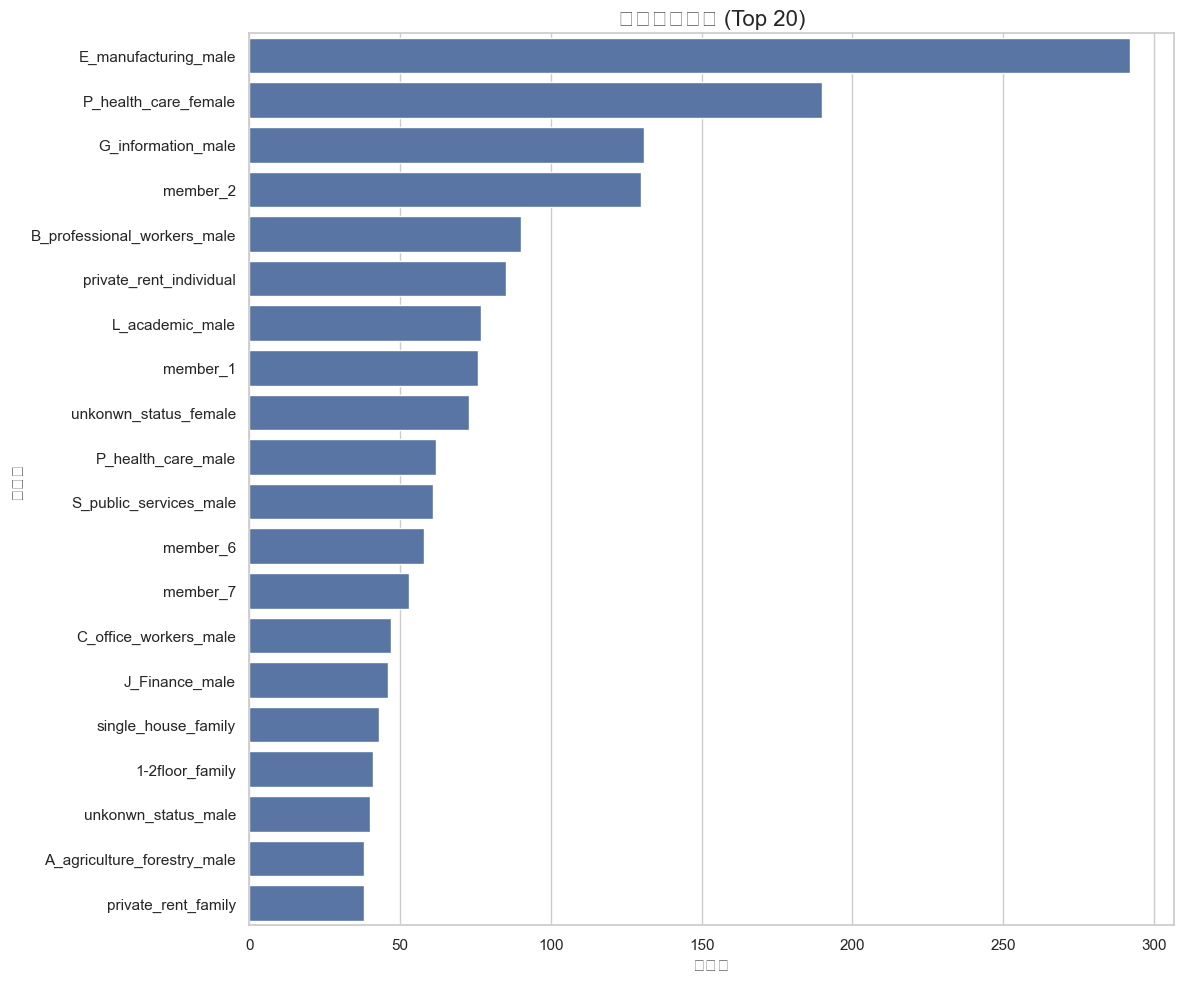

In [ ]:
#特徴量とターゲットを定義
target_column = 'income_mean'
features_to_drop = [col for col in key_columns if col in final_df.columns]
X = final_df.drop(columns=features_to_drop + [target_column])
y = final_df[target_column]

#train,testに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#LightGBMモデルの学習
model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

#予測と評価
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"テストデータでのRMSE: {rmse:.2f}")

#可視化
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

top_features = feature_importance_df.head(20)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('特徴量重要度 (Top 20)', fontsize=16)
plt.xlabel('重要度', fontsize=12)
plt.ylabel('特徴量', fontsize=12)
plt.tight_layout()
plt.show()